In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE

In [5]:
# Load data from CSV file into a pandas DataFrame
df = pd.read_csv("merged_zeek_logs.csv")

# Convert the DataFrame to a numpy array
labels = df.pop('label') #labels are separated
data_array = df.to_numpy()
print(df.columns)
print(data_array.shape)

Index(['id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p', 'duration',
       'orig_bytes', 'resp_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts',
       'resp_ip_bytes', 'is_icmp', 'http_count', 'ssl_count',
       'avg_seen_bytes_files', 'request_body_len', 'response_body_len',
       'dns_answer_count', 'avg_TTL', 'SLD_freq', 'query_length',
       'service_http', 'service_ssl', 'service_no_service', 'conn_state_RSTO',
       'conn_state_RSTR', 'conn_state_S0', 'conn_state_S1', 'conn_state_S3',
       'conn_state_SF', 'conn_state_SH', 'resumed_T', 'resumed_missing',
       'established_T', 'established_missing',
       'validation_status_not_provided', 'validation_status_missing',
       'method_POST', 'method_no_method', 'status_code_101', 'status_code_200',
       'status_code_204', 'status_code_missing', 'TLD_com', 'TLD_ms',
       'TLD_net', 'TLD_missing'],
      dtype='object')
(234, 47)


### Goal and methods
TODO: what si the goal? approach? kolik máme dat? crossvalidace? metriky?

## Feature selection, normalisation and dimensionality reduction

I will be using mostly sk-learn classes unless necessary to use something else, because I am familiar with the API and sk-learn offers all of the functionality I need for this.
I want to experiment with different data normalisation, feature selection, visualisation methods, dimensionality reduction and methods of outlier detection. 

Why outlier detection (OD)? I think it is the only useful ML paradigm for this task, because I have not been given all labeled data. I only have "benign" data, and only some of it. Hence, I want to recognize, that data "similar" to benign data is probably benign, and outliers/ radically different data MIGHT be malicious. I think, that in real systems, only a very small amount of traffic is malicious, but we really need to find it. Therefore, I will label everything not similar to my labeled benign as malicious. My system will have a large error, but I want to minimize False-Negative error on class of malicious data, which means capturing a lot of malicious data, but probably taking a lot of benign data with it.

#### Scaling

First before anything, we need to scale the data properly, so we can use other ML techniques.
I have 2 techniques in mind: Zero-mean and min-max normalisation. I would not use min-max here because I think there might be some outliers int he dataset, which could "throw off" scaling of some of the features. I think the dataset is very small and both methods would perform fine here, but zero mean normalisation is my more favourite one. :))

We will try using visualisation technique t-SNE (similar to U-map), which is a non linear-technique (as opposed to PCA for example).


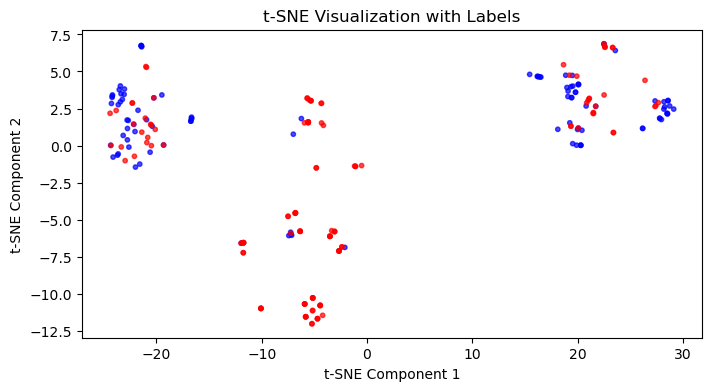

In [6]:
# zero-mean normalization
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data_array)

tsne = TSNE(n_components=2, random_state=11111)
tsne_results = tsne.fit_transform(normalized_data)

# Map labels to colors
label_colors = labels.map({'benign': 'blue', 'unknown': 'red'})

# Plot the t-SNE results with colors based on labels
plt.figure(figsize=(8, 4))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=label_colors, s=10, alpha=0.7)
plt.title("t-SNE Visualization with Labels")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

Blue points were labeled by me as benign based on provided information. this does not mean the red are all malicious, only that they might be. My thinking is, points close to many benign points are probably also benign?

#### Feature selection

I have 48 columns, but I assume some might have very similar contents (high corellation/colinearity/similarity). We can measure corellation of the columns or use my favourite technique, clustering!
Clustering the columns (features) might reveal similar features, which dont provide enough information. Agglomerative clustering can be used for this.

We do have 48 columns initially. We want smaller number, but if we "compress" the columns too much, then we lose a lot of important variation in the data.
This is also a part of the solution to the curse of dimensionality. We have very few data, hence we want to reduce the number of dimensions to prevent overfitting. Feature selection and dimensionality reduction are a good way to approach this. I'd like to have about 10x as many data as features, leading to about 20-25 features? This also depends on outlier detection technique used.


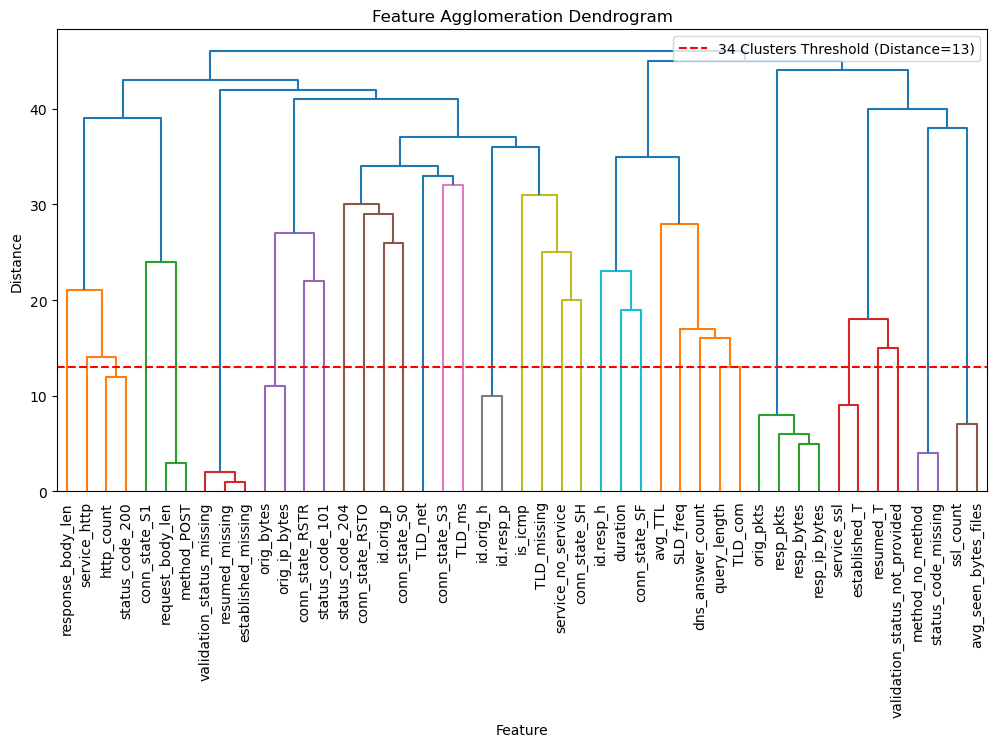

Number of clusters joined below the line: 12


In [4]:
n_clusters = 34
f_agg = cluster.FeatureAgglomeration(
    n_clusters=n_clusters, linkage="ward"
)  # ward, complete, average, single
featu_selected_data = f_agg.fit_transform(normalized_data)

n_features = normalized_data.shape[1]  
distances = np.arange(1, f_agg.children_.shape[0] + 1) 
linkage_matrix = np.column_stack(
    [
        f_agg.children_,  # Merging order
        distances,  # Estimated distances
        np.ones(f_agg.children_.shape[0]),  # Cluster sizes (not used but required)
    ]
).astype(float)


# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=df.columns, leaf_rotation=90, leaf_font_size=10)
plt.title("Feature Agglomeration Dendrogram")
plt.xlabel("Feature")
plt.ylabel("Distance")

# Plot the line for 40 clusters
threshold = distances[-n_clusters]  # Distance at which 40 clusters are formed
plt.axhline(
    y=threshold,
    color="r",
    linestyle="--",
    label=f"{n_clusters} Clusters Threshold (Distance={threshold})",
)

# Count how many clusters were joined below the line
joined_below_line = np.sum(distances < threshold)
plt.legend()
plt.show()

print(f"Number of clusters joined below the line: {joined_below_line}")

Dendrogram shows the order of "joining" of the clusets of features. closer to the bottom, the more similar they were.
We can see, that we have joined some of the features (below the line) and we can see which. This was calculated based on ward linkage (commonly used type of linkage between clusters)
On the vertical line, we can see the ward "distances" between pairs of clusters based on where they meet. Ward linkage is the criterion, which minimizes the variance of clusters being merged. 

We can see, that the closest features are established_missing and returned_missing, meaning those are very often together. There is a similarity between request body length and if the method for http request is POST. Both are 0 if the request is not http request at all. There are more similarities, which can be seen in the dendrogram at the bottom.

It is not clear which type of linkage to choose. I would not choose single linkage, this usually results in a sort of chaining (single linkage joint clusters which have the closest value inbetween some of their data). I used ward, since it is the standard, but average or complete would be good too. Complete is very computation heavy, but we have a small amount of data.

I have selected the amount of clusters by hand. We want less features, but not to distort the data too much. for example I think having http service and code 200 is very much connected, since almost all flows with http connection had code 200. Thats why I decided to merge the last two.

#### Dimensionality Reduction

kolik chci dimenzí? třeba 25-30? cca 1/10 např. záleží na modelech :))

#### Outlier detection

Tree-based models (Random Forest, XGBoost): Handle many features well but can still overfit.

Linear models (Logistic Regression, SVM): Sensitive to irrelevant features, so feature selection is crucial.

Neural networks: Generally need a lot of data relative to features.


label
unknown    132
benign     102

#### Visualisations